In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)


32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3
X,Y = [], []

for w in words:
    #print(w)
    contenxt = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(contenxt)
        Y.append(ix)
        #print(''.join(itos[i] for i in contenxt), '-->', itos[ix])

        contenxt = contenxt[1:] + [ix] # crop -remove first + append 
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype 

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [40]:
C = torch.rand((27, 2))

In [41]:
C[5]

tensor([0.4170, 0.9382])

In [44]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# 27, @ 27, 2
# Like a first layer 
# int @ flot -> nope 

tensor([0.4170, 0.9382])

In [47]:
C[torch.tensor([5, 6, 7])]
C[torch.tensor([5, 6, 7, 7,  7])]

tensor([[0.4170, 0.9382],
        [0.4673, 0.6043],
        [0.5565, 0.7477],
        [0.5565, 0.7477],
        [0.5565, 0.7477]])

In [48]:
C[X].shape

torch.Size([32, 3, 2])

In [49]:
X[13, 2]

tensor(1)

In [50]:
C[X][13,2]

tensor([0.4108, 0.1122])

In [51]:
C[1]

tensor([0.4108, 0.1122])

In [52]:
emb = C[X]
emb.shape 

torch.Size([32, 3, 2])

In [53]:
W1 = torch.randn((6, 100)) # 3 * 2 
b1 = torch.rand(100)

In [62]:
emb[:, 0, :].shape # First word 32, 2
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 1, :]], dim=1).shape

torch.Size([32, 6])

In [64]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [66]:
a = torch.arange(18)
a.view(2, 9) # 3, 3, 2
print(a.storage()) # storage offset, strides, shapes

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]


In [69]:
emb.view(32, 6).shape

torch.Size([32, 3, 2])

In [75]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape
# b1 -> "1", 100 ok 

torch.Size([32, 100])

In [77]:
W2 = torch.rand((100, 27)) # 27 chars 
b2 = torch.rand(27)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [79]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [80]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [82]:
prob[torch.arange(32), Y] # Prob of network 

tensor([3.8403e-02, 7.0592e-03, 1.7599e-03, 2.6821e-02, 6.5413e-03, 1.5030e-01,
        1.6646e-03, 2.3824e-03, 2.0726e-02, 2.5658e-03, 3.4209e-04, 1.3199e-02,
        6.1501e-04, 2.6742e-02, 2.5813e-02, 2.0209e-03, 8.4313e-04, 1.1306e-02,
        1.6984e-02, 1.0087e-03, 2.6100e-01, 3.1355e-02, 9.9775e-03, 3.6842e-02,
        5.9788e-03, 2.4443e-02, 1.5153e-01, 7.9555e-05, 6.9071e-03, 9.2070e-03,
        4.8175e-03, 1.0235e-02])

In [85]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(4.8609)

In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters)

3481

In [9]:
emb = C[X] # 32, 3, 2
h = torch.tanh((emb.view(-1, 6) @ W1) + b1) # 32, 100
logits = (h @ W2) + b2 # 32, 27 
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -(prob[torch.arange(32), Y].log()).mean()
loss = F.cross_entropy(logits, Y)  # Fushed kernel 
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [32]:
# e^100 -> inf -> ops 
# e^-100 -> close to zero fine 
# cross_entropy fix this 
# - 100
for p in parameters:
    p.requires_grad = True 

In [24]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # linearly to the exponents 
#lre at the end 1 
# Step LR 

In [35]:
lri = []
lossi = []
for i in range(100000): # overfit 32 ;p of 5 words 
    
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]] # 32, 3, 2
    h = torch.tanh((emb.view(-1, 6) @ W1) + b1) # 32, 100
    logits = (h @ W2) + b2 # 32, 27 
    for p in parameters:
        p.grad = None 
    
    loss = F.cross_entropy(logits, Y[ix])
    loss.backward()
    #lr = lrs[i]
    lr = 0.1
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #lri.append(lre[i])
    #lossi.append(loss.item())
print(loss.item())
#plt.plot(lri, lossi)

1.9937652349472046


In [119]:
logits.max(1)

torch.return_types.max(
values=tensor([13.0398, 17.0848, 20.3021, 20.1482, 16.2372, 13.0398, 15.5342, 13.7703,
        15.5154, 17.8000, 15.3920, 20.4114, 13.0398, 16.4957, 16.5941, 19.4904,
        13.0398, 16.1475, 14.4814, 16.4696, 18.1447, 15.4064, 10.3858, 10.2541,
        15.1862, 13.0398, 15.7258, 16.5125, 12.4300, 15.8490, 18.5210, 15.3460],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [120]:
Y # ... -> e, o, s, i etc first meh 
# Loss no zero 

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [130]:
torch.randint(0, X.shape[0], (32,))

tensor([151608, 170234,  40998, 105770,  37434,  86300, 100430, 186107,  50646,
         93757, 221642, 141549,  37466,  39001, 224388, 150211, 150755, 139803,
        213677, 175277,   3432, 204899, 199025, 103530,  55743,  97003, 214838,
        209506,  85838, 189624, 163389, 127198])

In [138]:
emb = C[X] # 32, 3, 2
h = torch.tanh((emb.view(-1, 6) @ W1) + b1) # 32, 100
logits = (h @ W2) + b2 # 32, 27 
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4496, grad_fn=<NllLossBackward0>)

In [130]:
# train, dev/val, test 
# 80, 10, 10

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182551, 3]) torch.Size([182551])
torch.Size([22783, 3]) torch.Size([22783])
torch.Size([22812, 3]) torch.Size([22812])


In [222]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 5), generator=g) # Beat karpathy less dims here ;p (kidding)
W1 = torch.randn((15, 150), generator=g)
b1 = torch.randn(150, generator=g)
W2 = torch.randn((150, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True 
sum(p.nelement() for p in parameters)

6612

TRAIN LOSS: 1.850675106048584


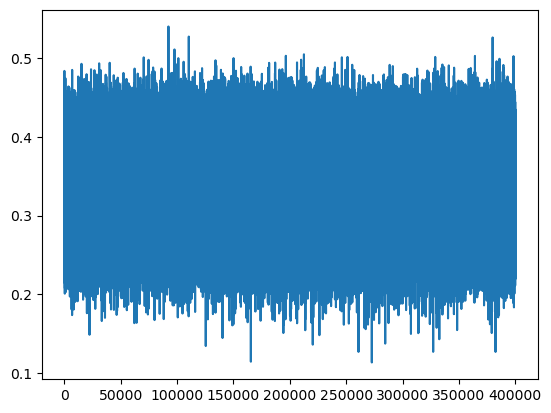

In [231]:
stepi = []
lossi = []
for i in range(400000): # overfit 32 ;p of 5 words 
    
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.relu((emb.view(-1, 15) @ W1) + b1) # 32, 100
    logits = (h @ W2) + b2 # 32, 27 
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None 
    
    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    lossi.append(loss.log10().item()) # log10 squashes 
    stepi.append(i)
print("TRAIN LOSS: " + str(loss.item()))
plt.plot(stepi, lossi)

In [232]:
emb = C[Xtr] # 32, 3, 2
h = torch.relu((emb.view(-1, 15) @ W1) + b1) # 32, 100
logits = (h @ W2) + b2 # 32, 27 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1852, grad_fn=<NllLossBackward0>)

In [233]:
emb = C[Xdev] # 32, 3, 2
h = torch.relu((emb.view(-1, 15) @ W1) + b1) # 32, 100
logits = (h @ W2) + b2 # 32, 27 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2040, grad_fn=<NllLossBackward0>)

In [234]:
"""plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    
plt.grid('minor')"""

'plt.figure(figsize=(8,8))\nplt.scatter(C[:, 0].data, C[:,1].data,s=200)\nfor i in range(C.shape[0]):\n    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color=\'white\')\n    \nplt.grid(\'minor\')'

In [237]:
g = torch.Generator().manual_seed(2147483647 + 10)


for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
                
        emb = C[torch.tensor([context])] # 32, 3, 2
        h = torch.relu((emb.view(-1, 15) @ W1) + b1) # 32, 100
        logits = (h @ W2) + b2 # 32, 27 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carma.
famorilvi.
kimlex.
taty.
ska.
sane.
mahnee.
den.
arci.
aqui.
ner.
kiah.
maiivon.
leigph.
bro.
kin.
quinn.
shor.
marian.
quisorro.
